# Titanic Survival Predictor

Logistic Regression offers a way to to create a fairly interpretable parametic model for binary classification. In this case it will be used to predict whether or not a passenger survived the sinking of the Titanic with the dataset [Kaggle's Titanic Data](https://www.kaggle.com/c/titanic/data)  

-----

The likelihood for Logistic Regression is given by

$$p(y_1,\ ...,\ y_n\ |\ x_1,\ ...,\ x_n,\ w)\ = \prod\limits_{i=1}^n\ \sigma_i(y_i \cdot w)$$  

The expression for the gradient of the log-likelihood with respect to $w$, 

$$\nabla_w \mathcal{L} = \sum_{i = 1}^n (1 − \sigma_i(y_i \cdot w))\ y_i x_i$$  

where $$\sigma_i(y_i \cdot w) = \frac{e^{y_iX_i^Tw}}{1+e^{y_ix_i^Tw}}$$  

In [77]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import itertools
import seaborn as sns

plt.rcParams['figure.figsize'] = (20.0, 10.0)

# Data Exploration

Demographic and trip information for each passenger is coupled with whether or not they survived the disaster.

In [39]:
tr_path = 'train.csv'
titanic_df = pd.read_csv(tr_path)

titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Dropping nulls

- Columns consisting mostly of missing data, that column probably will not be of much use in prediction.  
- Columns that have very few missing values, and enough records to build a model are complete, the records with missing values in that column may be cast out.  

In [40]:
# Cast out non-embarked individuals
tdf = titanic_df[titanic_df.Embarked.notnull()]

# Get rid of coolumns consisting of mostly missing data
tdf.dropna(axis = "columns", thresh = 450)

tdf

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


As age is likely related with survival and there is a large number of missing values for this feature we can make an educated guess for the missing values 

In [41]:
titanic_df['Age'].isnull().sum()

177

We will imput the ages using the $k$-Nearest-Neighbor `sklearn` algorithm.

We will need first to preprocess our data

In [42]:
# Drop irrelevant categories (in terms of our model)
titanic_df.drop(['Ticket','Cabin', 'PassengerId', 'Name'], axis=1, inplace=True)
titanic_df = titanic_df.loc[titanic_df['Embarked'].notnull(),:]

# Drop "Survived" (it is our target)
y_target = titanic_df.Survived
titanic_knn = titanic_df.drop(['Survived'], axis = 1)  
titanic_knn

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


Because `sklearn` automatically converts all data to floats before fitting models, it is necessary to encode any and all categorical variables as dummy variables

In [44]:
# Adding dummy variables for categorical vars
to_dummy = ['Sex','Embarked']
titanic_knn = pd.get_dummies(titanic_knn, prefix = to_dummy, columns = to_dummy, drop_first = True)

titanic_knn.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,3,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,3,35.0,0,0,8.0500,1,0,1


Splitting data - on whether or not "Age" is specified. Our training data will be the rows where age is not null

In [45]:
# Training data -- "Age" Not null; "Age" as target
train = titanic_knn[titanic_knn.Age.notnull()]
X_train = train.drop(['Age'], axis = 1)
y_train = train.Age

The data to impute is located where there are nulls at the "Age" column. Remove completely-null "Age" column.

In [47]:
impute = titanic_knn[titanic_knn.Age.isnull()].drop(['Age'], axis = 1)
print("Data to Impute")
print(impute)

Data to Impute
     Pclass  SibSp  Parch     Fare  Sex_male  Embarked_Q  Embarked_S
5         3      0      0   8.4583         1           1           0
17        2      0      0  13.0000         1           0           1
19        3      0      0   7.2250         0           0           0
26        3      0      0   7.2250         1           0           0
28        3      0      0   7.8792         0           1           0
..      ...    ...    ...      ...       ...         ...         ...
859       3      0      0   7.2292         1           0           0
863       3      8      2  69.5500         0           0           1
868       3      0      0   9.5000         1           0           1
878       3      0      0   7.8958         1           0           1
888       3      1      2  23.4500         0           0           1

[177 rows x 7 columns]


We preform the `sklearn` implementation

In [49]:
# Instantiate
knr = KNeighborsRegressor()

# Fit
knr.fit(X_train, y_train)

# Create Predictions
imputed_ages = knr.predict(impute)

Now that we have the predicted age values to impute in our data we can complete our old data frame

In [60]:
# Add to Df
impute['Age'] = imputed_ages
print("\nImputed Ages")
print(impute)

# Re-combine dataframes
titanic_imputed = pd.concat([train, impute], sort = False, axis = 0)

# Return to original order - to match back up with "Survived"
titanic_imputed.sort_index(inplace = True)
print("Shape with imputed values:", titanic_imputed.shape)
print("Shape before imputation:", titanic_knn.shape)

print("Nulls at 'Age' column:", titanic_imputed['Age'].isnull().sum())
titanic_imputed


Imputed Ages
     Pclass  SibSp  Parch     Fare  Sex_male  Embarked_Q  Embarked_S   Age
5         3      0      0   8.4583         1           1           0  47.2
17        2      0      0  13.0000         1           0           1  25.6
19        3      0      0   7.2250         0           0           0  23.0
26        3      0      0   7.2250         1           0           0  32.5
28        3      0      0   7.8792         0           1           0  21.7
..      ...    ...    ...      ...       ...         ...         ...   ...
859       3      0      0   7.2292         1           0           0  24.8
863       3      8      2  69.5500         0           0           1  37.0
868       3      0      0   9.5000         1           0           1  23.4
878       3      0      0   7.8958         1           0           1  33.0
888       3      1      2  23.4500         0           0           1  26.8

[177 rows x 8 columns]
Shape with imputed values: (889, 8)
Shape before imputation: (

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,3,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,3,35.0,0,0,8.0500,1,0,1
...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,1,0,1
887,1,19.0,0,0,30.0000,0,0,1
888,3,26.8,1,2,23.4500,0,0,1
889,1,26.0,0,0,30.0000,1,0,0


# Exploratory Data Analysis

In [63]:
# Lists of categorical v. numeric features
categorical = ['Pclass','Sex','Embarked']
numeric = ['Age','SibSp','Parch','Fare']

## Categorical variables

Take a look at tabulations of categorical variables. We first Create all pairs of categorical variables, 

In [64]:
cat_combos = list(itertools.combinations(categorical, 2))
print("All Combos or categorical vars: \n",cat_combos, "\n")

All Combos or categorical vars: 
 [('Pclass', 'Sex'), ('Pclass', 'Embarked'), ('Sex', 'Embarked')] 



and take a look at the distributions. 

These are simple cross tabulation of two (or more) factors. It computes a frequency table of the factors. 

In [66]:
for row, col in cat_combos:
    print("Row Percents: \n",pd.crosstab(titanic_df[row], titanic_df[col], normalize="index"), "\n")
    print("Column Percents: \n", pd.crosstab(titanic_df[row], titanic_df[col], normalize="columns"))
    print("\n---------------\n")

Row Percents: 
 Sex       female      male
Pclass                    
1       0.429907  0.570093
2       0.413043  0.586957
3       0.293279  0.706721 

Column Percents: 
 Sex       female      male
Pclass                    
1       0.294872  0.211438
2       0.243590  0.187175
3       0.461538  0.601386

---------------

Row Percents: 
 Embarked         C         Q         S
Pclass                                
1         0.397196  0.009346  0.593458
2         0.092391  0.016304  0.891304
3         0.134420  0.146640  0.718941 

Column Percents: 
 Embarked         C         Q         S
Pclass                                
1         0.505952  0.025974  0.197205
2         0.101190  0.038961  0.254658
3         0.392857  0.935065  0.548137

---------------

Row Percents: 
 Embarked         C         Q         S
Sex                                   
female    0.233974  0.115385  0.650641
male      0.164645  0.071057  0.764298 

Column Percents: 
 Embarked         C         Q         

## Numerical Variables

We will look at the heatmap

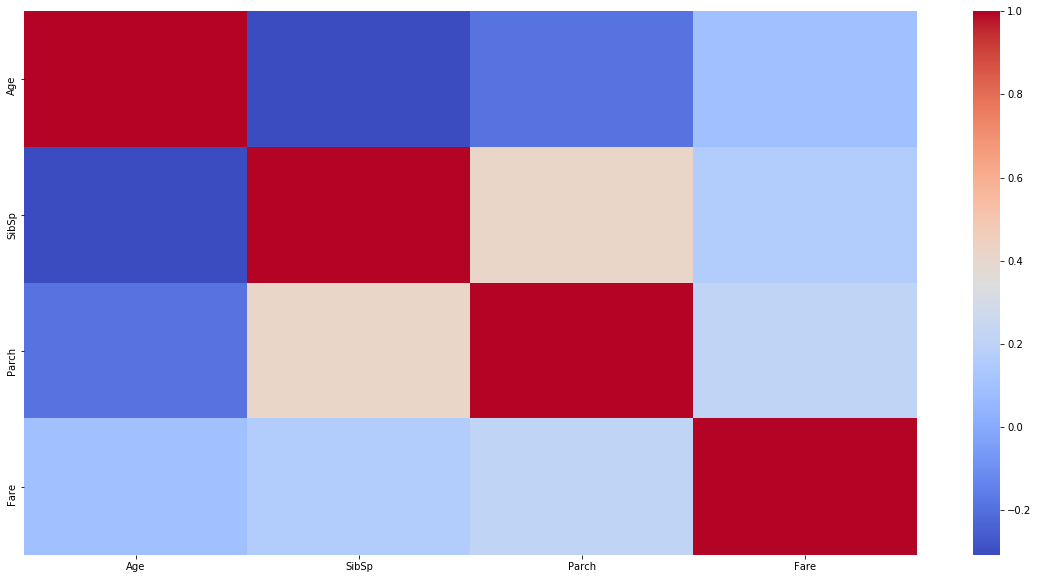

In [69]:
sns.heatmap(titanic_df[numeric].corr(), cmap = "coolwarm");

# Logistic Regression

We will start by preparing the data

In [70]:
def prepare_data(input_x, target_y):

    # Ensure shape of x-array
    if input_x.shape[0] < input_x.shape[1]:
        input_x = np.transpose(input_x)
        
    # Check size of y array, if necessary reshape to -1
    if len(target_y.shape) > 1:
        if min(target_y.shape) == 1:
            target_y.reshape(-1)
        else:
            print("Bad Y")
            
    # Create column of ones
    ones = np.ones((input_x.shape[0],1), dtype = int)
    
    # prepend column of ones
    augmented_x = np.concatenate((ones,input_x), axis = 1)
    
    # Ensure target is all -1 and 1
    target_y = np.array([x if x ==1 else -1 for x in target_y])
    
    # Create initial weights of 0s
    init_w = np.zeros(augmented_x.shape[1])
    
    # Return three numpy arrays
    return augmented_x, target_y, init_w

The next function will calculate the value of the sigmoid. 

$$\sigma_i(y_i \cdot w) = \frac{e^{y_iX_i^Tw}}{1+e^{y_ix_i^Tw}}$$  

In [71]:
def sigmoid_single(x, y, w):

    exponent = y*np.matmul(x.T,w)
    
    if exponent > 709.782:
        return 1
    else:
        exp = np.exp(exponent)
        
        return exp / (1+exp)

With the sigmoid, we will tackle the rest of the function that is summed to calculate the gradient of the log-likelihood.   

In [72]:
def to_sum(x,y,w):
    
    # Use function created above, multiply by x and y arrays.
    return (1- sigmoid_single(x,y,w))*y*x

In [73]:
def sum_all(x_input, y_target, w):

    # Create array of zeros for gradient
    grad = np.zeros(len(w))
    
    # iteratively sum for each element in x/y
    for x,y in zip(x_input, y_target):
        grad += to_sum(x,y,w)
        
    return grad

The function called `update_w`, performs a single-step of gradient descent for calculating the Logistic Regression weights, $w_{i+1} = w_i + \eta \sum_{i = 1}^n (1 − \sigma_i(y_i \cdot w_i))\ y_i x_i$

In [74]:
def update_w(x_input, y_target, w, eta):
    
    return w + (eta * sum_all(x_input, y_target, w))

`fixed_iteration` function performs gradient descent, calculating Logistic Regression weights for a specified number of steps.  

In [80]:
def fixed_iteration(x_input, y_target, eta, steps):
    
    # preprocess data
    x_input, y_target, w = prepare_data(x_input, y_target)
    for i in range(steps):
        w = update_w(x_input, y_target, w, eta)
    return w

A prediction will be created for out-of-sample data, label prediction for the x observations; either -1 or 1 (integers).  

In [81]:
def predict(x_input, weights):
    
    # Add intercept term to x
    x_input = np.insert(x_input, 0, 1)
    prod = np.matmul(x_input,weights)
    if prod > 0:
        return 1
    else:
        return -1

# Logistic Regression in `sklearn`

The following cells will demonstrate Logistic Regression using `sklearn`, and compare the custom Logistic Regression build in the previous functions to `sklearn's`

In [82]:
lr = LogisticRegression()

lr.fit(titanic_imputed, y_target)

# Create sklearn's predictions
sk_pred = lr.predict(titanic_imputed)

print(lr.intercept_)
print(lr.coef_)

[5.03793097]
[[-1.11400404e+00 -3.92839572e-02 -3.19506841e-01 -6.33633683e-02
   2.18505270e-03 -2.53833872e+00  2.49416467e-01 -2.61365174e-01]]


/home/juanda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [83]:
%%time
# This cell may take awhile
wt = fixed_iteration(titanic_imputed.values, y_target.values, .05, 12000)
wt

CPU times: user 1min 30s, sys: 0 ns, total: 1min 30s
Wall time: 1min 30s


array([  6853.75182849,   -831.23291018,   -304.24383135,  -2919.42190116,
        -1291.68658091,    218.83793151, -14297.98042097,     66.49415552,
          428.14909561])

In [84]:
cust_preds = np.array([predict(x,wt) for x in titanic_imputed.values])
cust_preds[cust_preds == -1] = 0

In [85]:
print("sklearn:")
print(classification_report(y_target, sk_pred))

print("Custom:")
print(classification_report(y_target, cust_preds))

sklearn:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       549
           1       0.77      0.70      0.74       340

    accuracy                           0.81       889
   macro avg       0.80      0.79      0.79       889
weighted avg       0.80      0.81      0.80       889

Custom:
              precision    recall  f1-score   support

           0       0.72      0.94      0.82       549
           1       0.82      0.41      0.54       340

    accuracy                           0.74       889
   macro avg       0.77      0.67      0.68       889
weighted avg       0.76      0.74      0.71       889

